In [2]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
from dotenv import dotenv_values
import json
import requests

%matplotlib inline

In [4]:
config = dotenv_values('.env')

#Authentication - without user
client_credentials_manager = SpotifyClientCredentials(client_id=config['client_id'], client_secret=config['client_secret'])
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

playlist_link = "https://open.spotify.com/playlist/37i9dQZF1E4DxWTWjR3190"
playlist_URI = playlist_link.split("/")[-1].split("?")[0]
track_uris = [x["track"]["uri"] for x in sp.playlist_tracks(playlist_URI)["items"]]

Collect feature to measure

In [3]:
pprint.pprint(sp.audio_features(track_uris)[0])

{'acousticness': 0.572,
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/2oDR7QWoLBk9VYMwsFbRGq',
 'danceability': 0.188,
 'duration_ms': 295693,
 'energy': 0.12,
 'id': '2oDR7QWoLBk9VYMwsFbRGq',
 'instrumentalness': 0.42,
 'key': 1,
 'liveness': 0.0933,
 'loudness': -20.95,
 'mode': 1,
 'speechiness': 0.0366,
 'tempo': 110.244,
 'time_signature': 3,
 'track_href': 'https://api.spotify.com/v1/tracks/2oDR7QWoLBk9VYMwsFbRGq',
 'type': 'audio_features',
 'uri': 'spotify:track:2oDR7QWoLBk9VYMwsFbRGq',
 'valence': 0.0379}


In [4]:
instrumentalnesses = [features['instrumentalness'] for features in sp.audio_features(track_uris)]
speechinesses = [features['speechiness'] for features in sp.audio_features(track_uris)]
time_signatures = [features['time_signature'] for features in sp.audio_features(track_uris)]

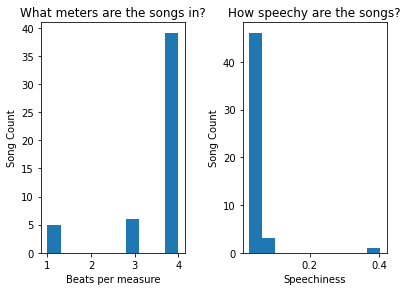

In [5]:
#Create Histograms
fig, ax = plt.subplots(1, 2)
ax[0].hist(time_signatures)
ax[0].set_title("What meters are the songs in?")
# adding labels
ax[0].set_xlabel('Beats per measure')
ax[0].set_ylabel('Song Count')

ax[1].hist(speechinesses)
ax[1].set_title("How speechy are the songs?")
# adding labels
ax[1].set_xlabel('Speechiness')
ax[1].set_ylabel('Song Count')

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

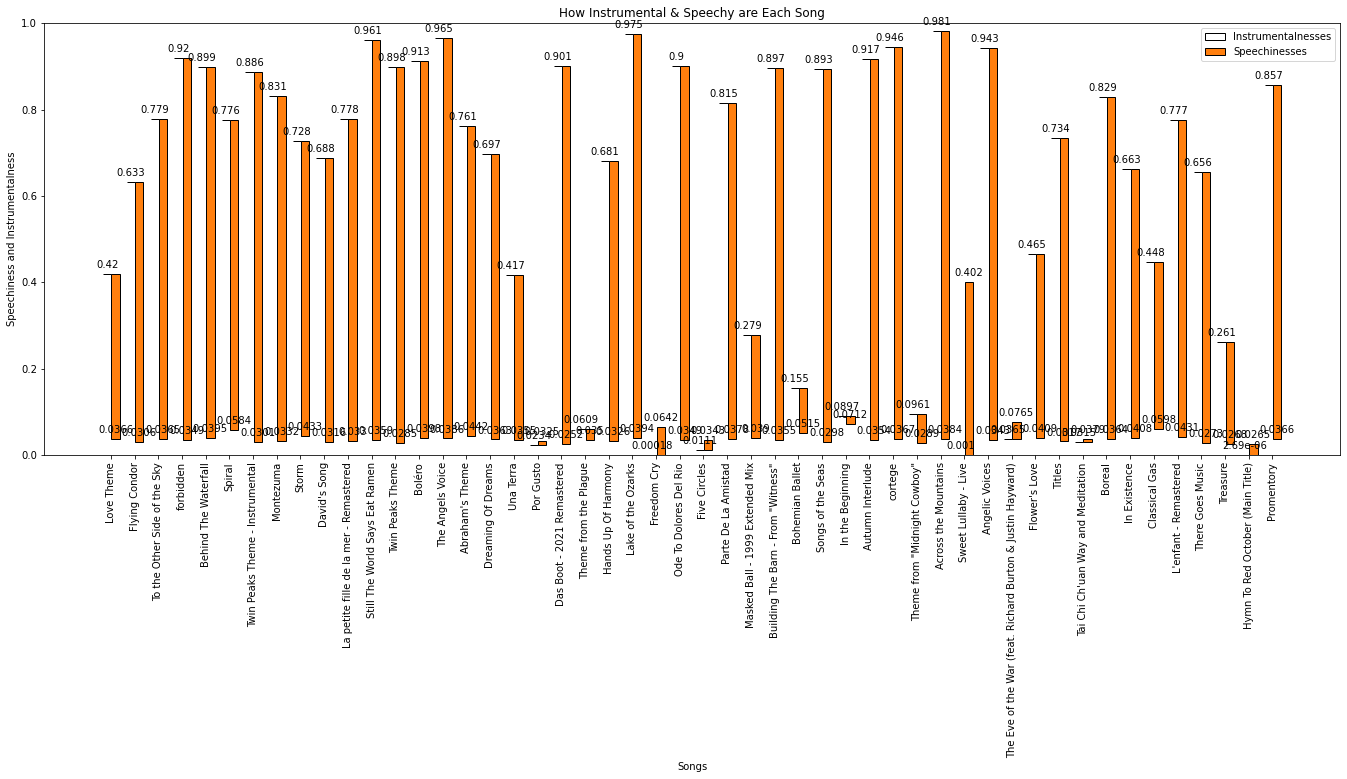

In [7]:
def hat_graph(ax, xlabels, values, group_labels):
    """
    Create a hat graph.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The Axes to plot into.
    xlabels : list of str
        The category names to be displayed on the x-axis.
    values : (M, N) array-like
        The data values.
        Rows are the groups (len(group_labels) == M).
        Columns are the categories (len(xlabels) == N).
    group_labels : list of str
        The group labels displayed in the legend.
    """

    def label_bars(heights, rects):
        """Attach a text label on top of each bar."""
        for height, rect in zip(heights, rects):
            ax.annotate(f'{height}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 4),  # 4 points vertical offset.
                        textcoords='offset points',
                        ha='center', va='bottom')

    values = np.asarray(values)
    x = np.arange(values.shape[1])
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, rotation=90)
    spacing = 0.3  # spacing between hat groups
    width = (1 - spacing) / values.shape[0]
    heights0 = values[0]
    for i, (heights, group_label) in enumerate(zip(values, group_labels)):
        style = {'fill': False} if i == 0 else {'edgecolor': 'black'}
        rects = ax.bar(x - spacing/2 + i * width, heights - heights0,
                       width, bottom=heights0, label=group_label, **style)
        label_bars(heights, rects)

xlabels = [x["track"]["name"] for x in sp.playlist_tracks(playlist_URI)["items"]]

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 3.0, 1.5])
hat_graph(ax, xlabels, [instrumentalnesses, speechinesses], ['Instrumentalnesses', 'Speechinesses'])
ax.set_xlabel('Songs')
ax.set_ylabel('Speechiness and Instrumentalness')
ax.set_ylim(0, 1)
ax.set_title('How Instrumental & Speechy are Each Song')
ax.legend()

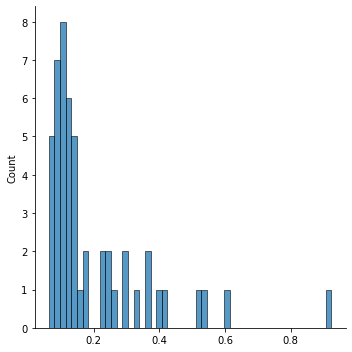

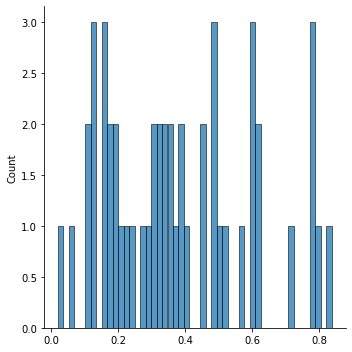

In [5]:
liveliness = [features['liveness'] for features in sp.audio_features(track_uris)]
sns.displot(liveliness, bins=50)
energies = [features['energy'] for features in sp.audio_features(track_uris)]
sns.displot(energies, bins=50)

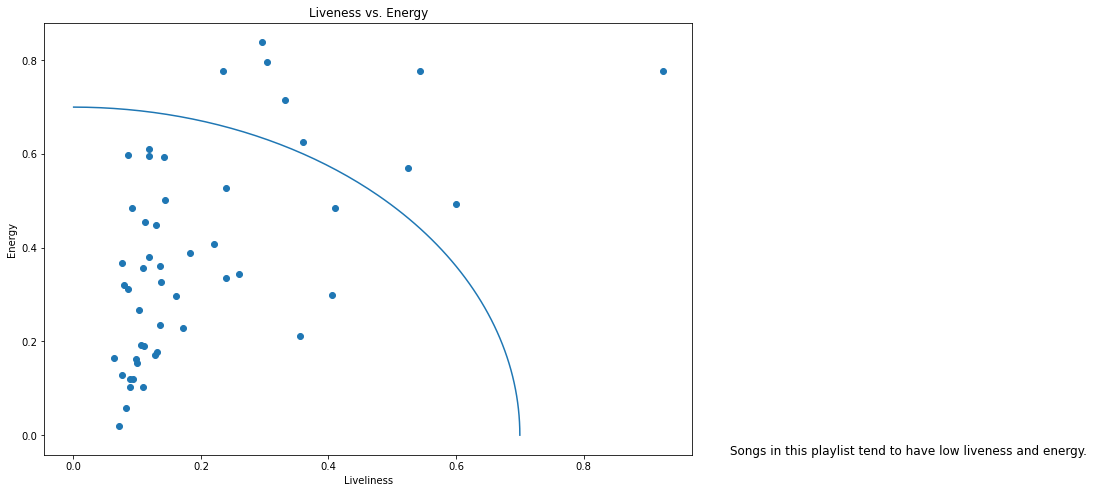

In [6]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 1.5, 1.5])
r0 = 0.7
ax.set_xlabel('Liveliness')
ax.set_ylabel('Energy')
ax.set_title('Liveness vs. Energy')
plt.scatter(liveliness, energies)
plt.figtext(2.1, 0.1, "Songs in this playlist tend to have low liveness and energy.", wrap=True, horizontalalignment='center', fontsize=12)
theta = np.arange(0, np.pi / 2, 0.01)
plt.plot(r0 * np.cos(theta), r0 * np.sin(theta))